##  Startvorteil
In folgendem Abschnitt werden die Startpositionen der KIs analysiert.
Da das generierte Spielbrett zufällig und nicht ausgeglichen erstellt wird kann hiermit festgestellt werden welche KI daraus Vorteile erlangt.

Während des Spielens von 100 Spielen, also 200 KIs wurden die Daten protokolliert.
Beide KIs spielen mit den selben Parametern.
Es ist klar zu sehen das die Startposition <437,5,200> der <3468,5,985> vorzuziehen ist, da von dieser 81 von 100 Spielen gewonnen wurden.

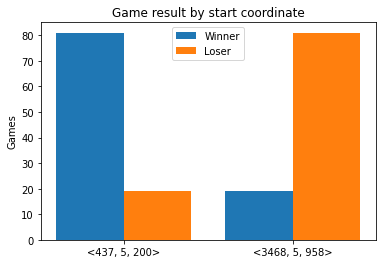

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_static = pd.read_csv('Data/STATIC.csv', index_col=[0], sep=';')
df_ref = pd.read_csv('Data/REF.csv', index_col=[0], sep=';')
frames = [df_static, df_ref]

result = pd.concat(frames)
winSum = result.groupby('Coord')['Winner'].value_counts()
won = winSum.take([0, 3])
los = winSum.take([1, 2])

labels = result.Coord.unique() # labels of x-axis
width = 0.40  # bar width

x = np.arange(2)
fig, ax = plt.subplots() # merge two plots
ax.bar(x - width/2, won, width, label='Winner')
ax.bar(x + width/2, los, width, label='Loser')
ax.set_ylabel('Games')
ax.set_title('Game result by start coordinate')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

plt.rcParams["figure.figsize"] = (6,4)
plt.show()

## Erste KI Evolution
Diese erste Evolution nutzt die statische KI.
Dabei werden die Parameter dieser mit einem Evolutionären Algorithmus optimiert.

| Parameter |Definitionen für EA||
| :- |:-|:-|
| Min. Leben von einer Stadt um anzugreifen |Repräsentation|Integer|
| Min./Max. Suchradius nach angreifbaren Städten |Selektion|Tunier-Selektion|
| Schrittweite beim Erweitern des Suchradius |Rekombination|arithmetischer Crossover (70%)|
||Mutation|Creep Mutation |

In folgendem Abschnitt werden die Daten aufbereitet und ergänzt. Dabei wird im ersten Codeabschnitt nur mit den Daten direkt aus dem EA gearbeitet. Im zweiten Abschnitt werden weitere Daten berechnet, wie zum Beispiel der Durchschnitt oder die Standardabweichung aller KIs in jeder Evolution.

In [41]:
df_EA = pd.read_csv('Data/EA1.csv', index_col=[0], sep=';')
#df_EA = pd.read_csv('Data/EA_losepos_newFit200.csv', index_col=[0], sep=';')
#df_EA = pd.read_csv('Data/EA_winpos_newFit200.csv', index_col=[0], sep=';')
#df_EA = pd.read_csv('Data/EA_winpos.csv', index_col=[0], sep=';')
#df_EA = pd.read_csv('Data/EA_winpos_bad.csv', index_col=[0], sep=';')
evolutions = df_EA.groupby(df_EA.index).size().iloc[:1].values # get the number of evolutions
KINumber = df_EA.groupby(df_EA.index).size().size # get the number of different KIs (individuals)
df_EA['Evolution'] = np.arange(evolutions).repeat(KINumber) # add new evolution column
df_EA = df_EA.reset_index().set_index(['Evolution', 'Name']) #make multiindex

### Calulate more Data for analysis
df_Mean = df_EA.groupby(level=0).agg(['mean']).stack(1) # calc mean for every evolution -> does not calc when 100% false/true!
df_Mean = df_Mean.reset_index().set_index(['Evolution']) #remove multiindex
df_Mean.drop(['Winner', "level_1"], axis=1, inplace=True) # remove useless columns
### Calculates the win percentage of each evolution.
df_wincounter = df_EA.groupby(level=0)['Winner'].value_counts().unstack(fill_value=0).stack().to_frame()
df_cleaned = df_wincounter.rename(columns={0: "WinPercent"}).reset_index().set_index(['Evolution'])
df_winner = df_cleaned.loc[df_cleaned['Winner'] == True]
df_winner.drop(['Winner'], axis=1) # remove useless columns
df_Mean['WinPercent'] = df_winner['WinPercent'].apply(lambda x: x / KINumber * 100) # calculate winpercentage
### Calculate standard deviation
df_standardDeviation = df_EA.std(axis = 0, skipna = True, level = 0)
df_standardDeviation.drop(['Winner', "Fitness", "Score", "GameTime"], axis=1, inplace=True)
df_Mean

,Fitness,Score,GameTime,InitialConquerRadius,MaxConquerRadius,RadiusExpansionStep,AttackMinLife,WinPercent
Evolution,,,,,,,,
0,72.175,72.175,144.170,1972.470,2092.395,6.830,50.055,4.5
1,93.875,93.875,144.030,2012.535,2434.630,8.940,53.385,6.0
2,119.500,119.500,154.150,2221.930,2665.250,-10.375,49.455,7.5
3,112.075,112.075,149.520,1561.265,2525.380,47.010,48.840,7.0
4,190.625,190.625,192.515,1457.860,2881.510,455.710,44.880,12.0
...,...,...,...,...,...,...,...,...
65,323.375,323.375,200.000,3034.000,3319.000,2959.000,5.000,37.0
66,368.875,368.875,250.000,3025.000,3312.000,2955.000,5.000,40.0
67,377.550,377.550,200.000,3015.000,3309.000,2953.000,5.000,53.5


Im nächsten Codeteil werden die oben errechneten Daten visualisiert. Dies geschieht immer im Vergleich zu der Zeit die die Spiele benötigt haben um die Gewinnen oder zu Verlieren. Auskommentierte Codezeilen können angezeigt werden indem das #-Symbol entfernt wird. Zudem kann mit zwei verschiedenen Datensätzen gearbeitet werden. <strong>df_EA['Name_der_Eigenschaft'] </strong>beinhaltet die Ursprungsdaten während <strong>df_Mean['Name_der_Eigenschaft']</strong> und <strong>df_standardDeviation['Name_der_Eigenschaft']</strong> berechnete Daten enthält.

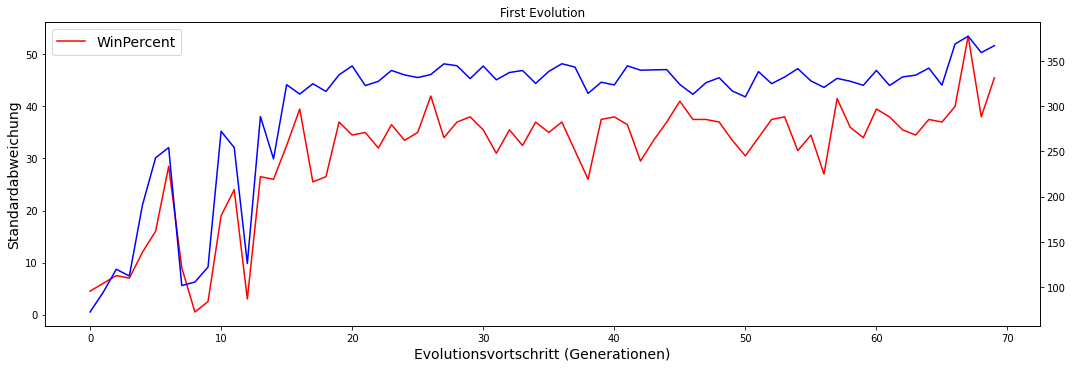

In [43]:
plt.rcParams["figure.figsize"] = (15,5)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Evolutionsvortschritt (Generationen)', fontsize=14)
ax1.set_ylabel('Standardabweichung', fontsize=14)
#AttackMinLife, = ax1.plot(df_EA["AttackMinLife"].values, color='red', label='AttackMinLife')
#RadiusExpansionStep, = ax1.plot(df_EA["RadiusExpansionStep"].values, color='red', label='RadiusExpansionStep')
#MaxConquerRadius, = ax1.plot(df_EA["MaxConquerRadius"].values, color='green', label='MaxConquerRadius')
#InitialConquerRadius, = ax1.plot(df_EA["InitialConquerRadius"].values, color='black', label='InitialConquerRadius')
#Score, = ax1.plot(df_EA["Score"].values, color='red', label='Score')
#Fitness, = ax1.plot(df_EA["Fitness"].values, color='red', label='Fitness')
#TownLifeSum, = ax1.plot(df_EA["TownLifeSum"].values, color='red', label='TownLifeSum')

WinPercent, = ax1.plot(df_Mean['WinPercent'].values, color='red', label='WinPercent')
#Fitness, = ax1.plot(df_Mean["AttackMinLife"].values, color='red', label='Fitness')
#std, = ax1.plot(df_standardDeviation["RadiusExpansionStep"].values, color='red', label='RadiusExpansionStep')
#std1, = ax1.plot(df_standardDeviation["MaxConquerRadius"].values, color='green', label='MaxConquerRadius')
#std2, = ax1.plot(df_standardDeviation["InitialConquerRadius"].values, color='black', label='InitialConquerRadius')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color='blue'
#ax2.set_ylabel('Fitness', color=color, fontsize=14)
#ax2.plot(df_Mean["GameTime"].values, color=color)
ax2.plot(df_Mean["Fitness"].values, color=color)
#ax2.plot(df_EA["GameTime"].values, color=color)
ax2.tick_params(axis='y')

fig.tight_layout()
plt.title('First Evolution')
plt.legend(handles = [WinPercent], fontsize=14)
plt.show()

### Auswertung

Die von EA entwickelten Parameterwerte sind in folgender Tabelle zu sehen. Es sind die Werte der letzten Evolution aus dem EA_winpos_newFit200 Datensatz. Diese Parameter können nun wieder eingesetzt werden um ein um einen Vergleich beider KIs mit konstanten Eigenschaften zu bekommen. In der zweiten Tabelle ist zu sehen das mit den neuen Parametern selbst von der benachteilten Position gewonnen wird.

In [7]:
df_Mean.iloc[-1].to_frame().T

,Fitness,TownLifeSum,Score,GameTime,InitialConquerRadius,MaxConquerRadius,RadiusExpansionStep,AttackMinLife,WinPercent
99,330.75,52.68,337.75,7150.0,590.0,2853.0,268.0,5.0,100.0


In [56]:
df_const = pd.read_csv('Data/EA_constParamTest.csv', index_col=[0], sep=';')
df_const[['Coord', 'Winner']].value_counts().to_frame().rename(columns={0 : "Number"})

,,Number
Coord,Winner,
"<3468, 5, 958>",True,200
